In [3]:
# load orders.csv file
import pandas as pd
orders = pd.read_csv('orders.csv')
print(f"Shape: {orders.shape}")
print(f"Columns: {orders.columns.tolist()}")
print(f"Date range: {orders['order_date'].min()} to {orders['order_date'].max()}")

Shape: (10000, 6)
Columns: ['order_id', 'user_id', 'restaurant_id', 'order_date', 'total_amount', 'restaurant_name']
Date range: 01-01-2023 to 31-12-2023


In [4]:
# load users.join file
import json
with open('users.json', 'r') as f:
    users_data = json.load(f)
users = pd.DataFrame(users_data)
print(f"Shape: {users.shape}")
print(f"Columns: {users.columns.tolist()}")
print(f"User ID range: {users['user_id'].min()} to {users['user_id'].max()}")

Shape: (3000, 4)
Columns: ['user_id', 'name', 'city', 'membership']
User ID range: 1 to 3000


In [5]:
# load restaurants.sql file
import re

with open('restaurants.sql', 'r') as f:
    sql_content = f.read()

# Extracting restaurant data
insert_pattern = r'INSERT INTO restaurants VALUES \((.*?)\);'
matches = re.findall(insert_pattern, sql_content)

restaurants_list = []
for match in matches:
    values = match.split(',')
    restaurants_list.append({
        'restaurant_id': int(values[0]),
        'restaurant_name': values[1].strip().strip("'"),
        'cuisine': values[2].strip().strip("'"),
        'rating': float(values[3])
    })

restaurants = pd.DataFrame(restaurants_list)
print(f"Shape: {restaurants.shape}")
print(f"Columns: {restaurants.columns.tolist()}")
print(f"Restaurant ID range: {restaurants['restaurant_id'].min()} to {restaurants['restaurant_id'].max()}")

Shape: (500, 4)
Columns: ['restaurant_id', 'restaurant_name', 'cuisine', 'rating']
Restaurant ID range: 1 to 500


In [6]:
# checking missing values and duplicates
datasets = [("Orders", orders), ("Users", users), ("Restaurants", restaurants)]

for name, data in datasets:
    missing_count = data.isnull().sum().sum()
    duplicate_count = data.duplicated().sum()
    print(f"{name}: Missing values={missing_count}, Duplicates={duplicate_count}")

Orders: Missing values=0, Duplicates=0
Users: Missing values=0, Duplicates=0
Restaurants: Missing values=0, Duplicates=0


In [7]:
# change order date to datetime
orders['order_date'] = pd.to_datetime(orders['order_date'], format='%d-%m-%Y')

# merging orders and users
merged_data = pd.merge(orders, users, on='user_id', how='left')

# join with restaurants
final_data = pd.merge(merged_data, restaurants, on='restaurant_id', how='left')

# saving final data
final_data.to_csv('final_food_delivery_dataset.csv', index=False)
print(f"Final dataset shape: {final_data.shape}")
print(f"File saved: final_food_delivery_dataset.csv")
print(f"Total orders: {len(final_data)}")
print(f"Date range: {final_data['order_date'].min().date()} to {final_data['order_date'].max().date()}")

Final dataset shape: (10000, 12)
File saved: final_food_delivery_dataset.csv
Total orders: 10000
Date range: 2023-01-01 to 2024-01-01


In [11]:
import micropip
await micropip.install('seaborn')

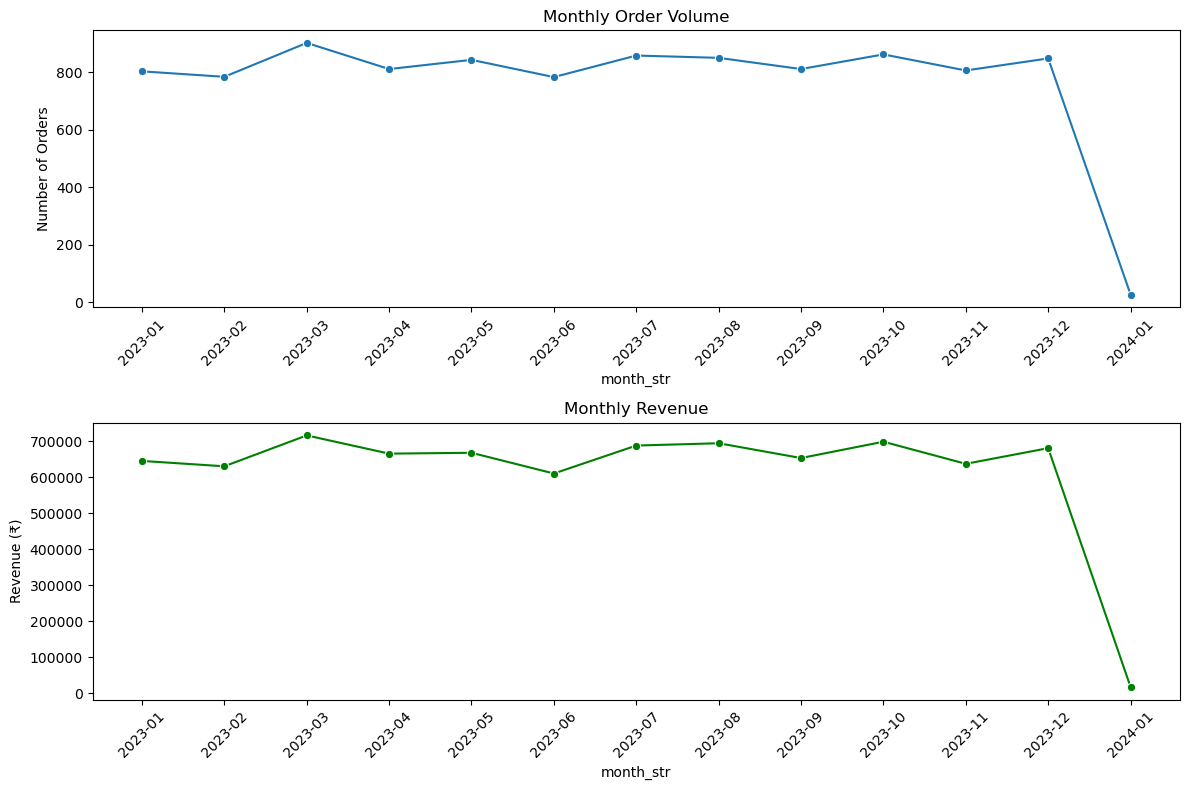

Highest revenue quarter = Q3
Peak month for orders: 2023-03
Peak month for revenue: 2023-03
Average monthly orders: 769


In [14]:
# order trends over time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# converting period to string for plotting monthly trends
final_data['month_str'] = final_data['order_date'].dt.strftime('%Y-%m')
monthly_trends = final_data.groupby('month_str').agg(
    orders=('order_id', 'count'),
    revenue=('total_amount', 'sum'),
    avg_value=('total_amount', 'mean')
).reset_index().sort_values('month_str')

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# plot 1 - orders per month
sns.lineplot(data=monthly_trends, x='month_str', y='orders', ax=axes[0], marker='o')
axes[0].set_title('Monthly Order Volume')
axes[0].set_ylabel('Number of Orders')
axes[0].tick_params(axis='x', rotation=45)

# plot 2 - revenue per month
sns.lineplot(data=monthly_trends, x='month_str', y='revenue', ax=axes[1], marker='o', color='green')
axes[1].set_title('Monthly Revenue')
axes[1].set_ylabel('Revenue (₹)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# quarterly trends
final_data['quarter'] = final_data['order_date'].dt.quarter
quarterly_revenue = final_data.groupby('quarter')['total_amount'].sum()
print(f"Highest revenue quarter = Q{quarterly_revenue.idxmax()}")

# insights
print(f"Peak month for orders: {monthly_trends.loc[monthly_trends['orders'].idxmax(), 'month_str']}")
print(f"Peak month for revenue: {monthly_trends.loc[monthly_trends['revenue'].idxmax(), 'month_str']}")
print(f"Average monthly orders: {monthly_trends['orders'].mean():.0f}")

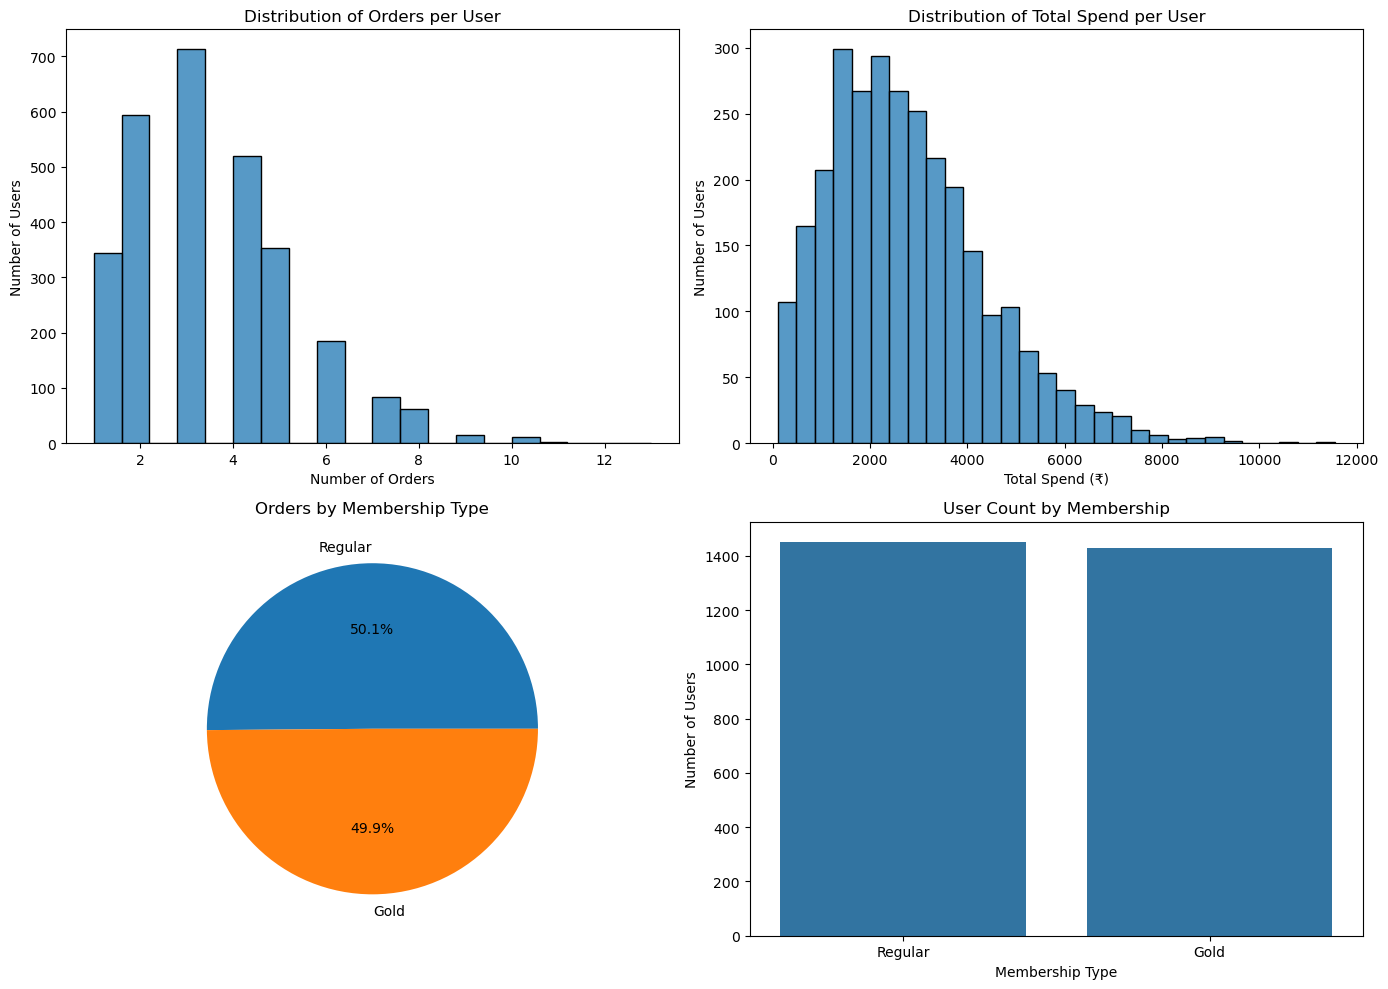

Users with total spend > ₹1000 = 2544 (> 2000)
Total distinct users: 2883
Average orders per user: 3.47
Average spend per user: ₹2778.92
Repeat customers (>1 order): 2539 users


In [16]:
# user behavior analysis
user_stats = final_data.groupby('user_id').agg(
    order_count=('order_id', 'count'),
    total_spent=('total_amount', 'sum'),
    avg_order_value=('total_amount', 'mean'),
    membership=('membership', 'first')
).reset_index()

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# plot 1 - distribution of orders per user
sns.histplot(data=user_stats, x='order_count', bins=20, ax=axes[0,0])
axes[0,0].set_title('Distribution of Orders per User')
axes[0,0].set_xlabel('Number of Orders')
axes[0,0].set_ylabel('Number of Users')

# plot 2 - distribution of total spend
sns.histplot(data=user_stats, x='total_spent', bins=30, ax=axes[0,1])
axes[0,1].set_title('Distribution of Total Spend per User')
axes[0,1].set_xlabel('Total Spend (₹)')
axes[0,1].set_ylabel('Number of Users')

# plot 3 - orders distribution by membership
membership_orders = final_data['membership'].value_counts()
axes[1,0].pie(membership_orders.values, labels=membership_orders.index, autopct='%1.1f%%')
axes[1,0].set_title('Orders by Membership Type')

# users with total spend over 1000 plot
high_spend_users = user_stats[user_stats['total_spent'] > 1000]
count = len(high_spend_users)
if count < 500:
    value = "< 500"
elif 500 <= count <= 1000:
    value = "500 – 1000"
elif 1001 <= count <= 2000:
    value = "1000 – 2000"
else:
    value = "> 2000"

sns.countplot(data=user_stats, x='membership', ax=axes[1,1])
axes[1,1].set_title('User Count by Membership')
axes[1,1].set_xlabel('Membership Type')
axes[1,1].set_ylabel('Number of Users')

plt.tight_layout()
plt.show()

print(f"Users with total spend > ₹1000 = {count} ({value})")

# insights
print(f"Total distinct users: {user_stats.shape[0]}")
print(f"Average orders per user: {user_stats['order_count'].mean():.2f}")
print(f"Average spend per user: ₹{user_stats['total_spent'].mean():.2f}")
print(f"Repeat customers (>1 order): {(user_stats['order_count'] > 1).sum()} users")

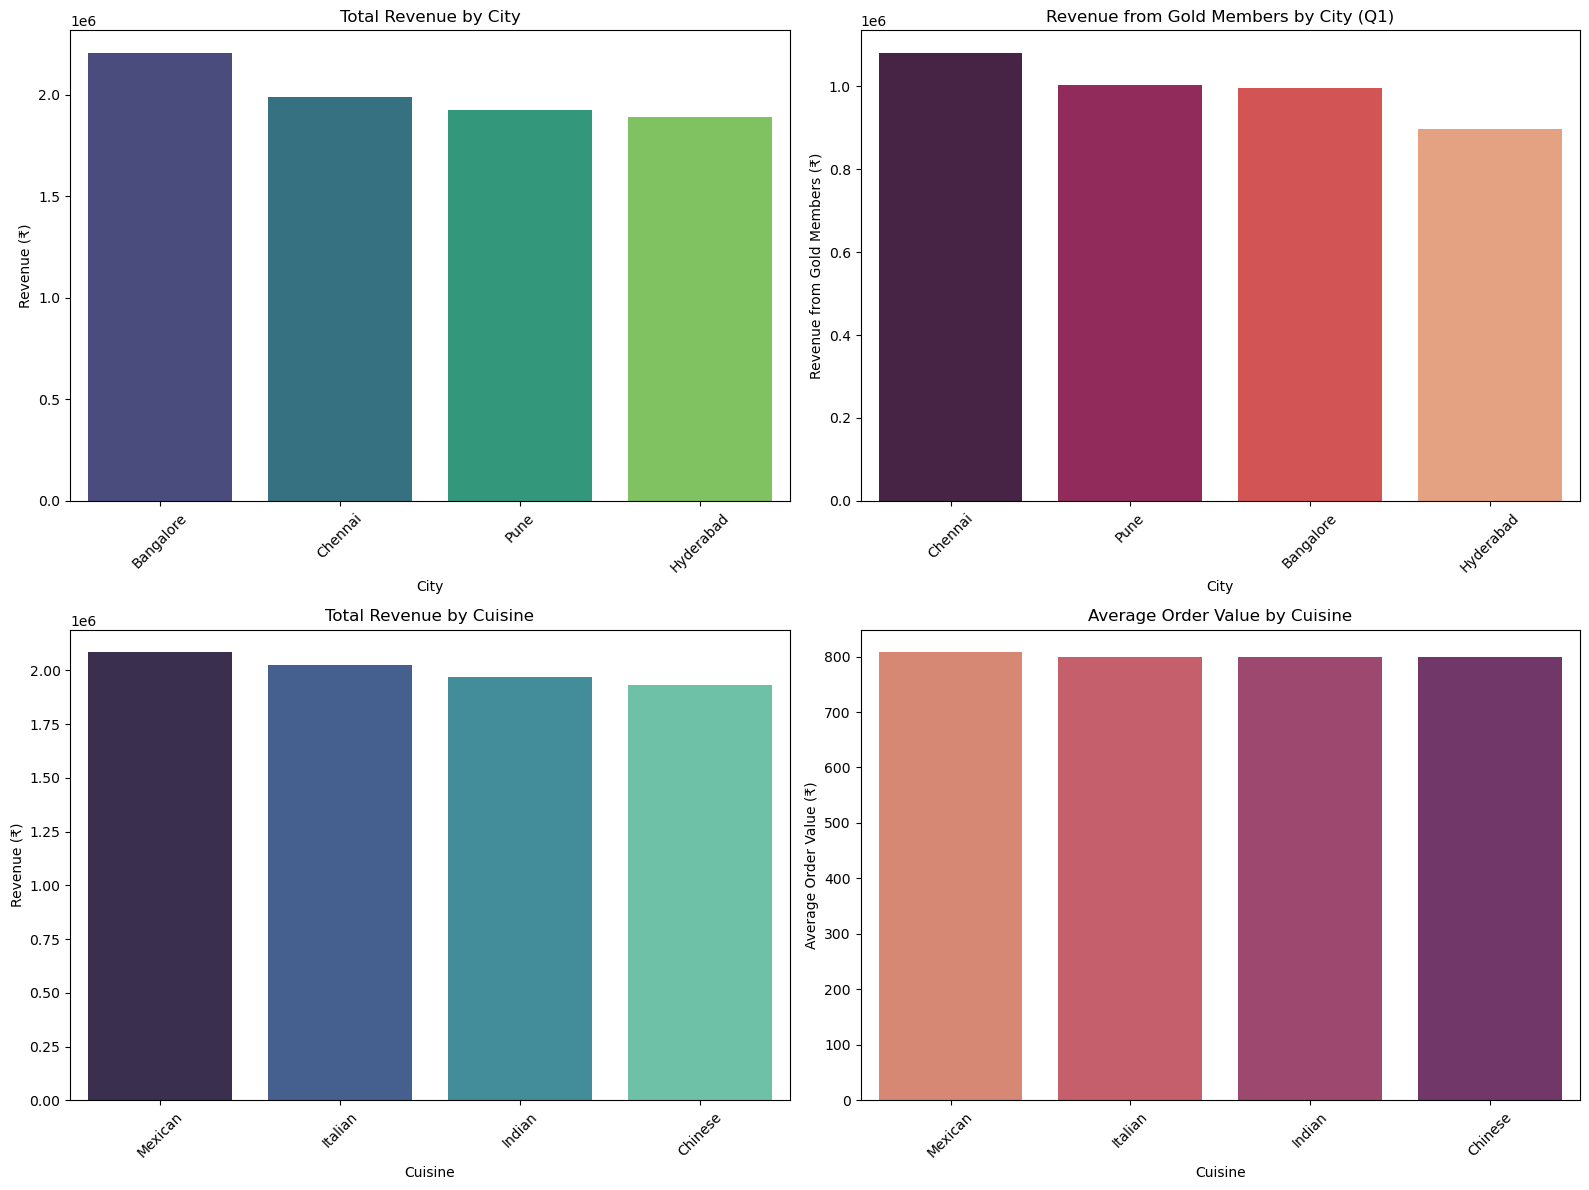

City with highest revenue from Gold members = Chennai
Cuisine with highest average order value = Mexican
City with highest avg order value for Gold members = Chennai
Cuisine with fewest restaurants but high revenue = Mexican

Top 3 cities by revenue: ['Bangalore', 'Chennai', 'Pune']
Top 3 cuisines by revenue: ['Mexican', 'Italian', 'Indian']


In [37]:
# city-wise and cuisine-wise performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# plot 1 - revenue by city
city_revenue = final_data.groupby('city')['total_amount'].sum().sort_values(ascending=False)
sns.barplot(x=city_revenue.index, y=city_revenue.values, hue=city_revenue.index, ax=axes[0,0], palette='viridis', legend=False)
axes[0,0].set_title('Total Revenue by City')
axes[0,0].set_xlabel('City')
axes[0,0].set_ylabel('Revenue (₹)')
axes[0,0].tick_params(axis='x', rotation=45)

# plot 2 - revenue by city for Gold members
gold_data = final_data[final_data['membership'] == 'Gold']
city_gold_revenue = gold_data.groupby('city')['total_amount'].sum().sort_values(ascending=False)
sns.barplot(x=city_gold_revenue.index, y=city_gold_revenue.values, hue=city_gold_revenue.index, ax=axes[0,1], palette='rocket', legend=False)
axes[0,1].set_title('Revenue from Gold Members by City (Q1)')
axes[0,1].set_xlabel('City')
axes[0,1].set_ylabel('Revenue from Gold Members (₹)')
axes[0,1].tick_params(axis='x', rotation=45)

# plot 3 - revenue by cuisine
cuisine_revenue = final_data.groupby('cuisine')['total_amount'].sum().sort_values(ascending=False)
sns.barplot(x=cuisine_revenue.index, y=cuisine_revenue.values, hue=cuisine_revenue.index, ax=axes[1,0], palette='mako', legend=False)
axes[1,0].set_title('Total Revenue by Cuisine')
axes[1,0].set_xlabel('Cuisine')
axes[1,0].set_ylabel('Revenue (₹)')
axes[1,0].tick_params(axis='x', rotation=45)

# plot 4 - average order value by cuisine
cuisine_avg_value = final_data.groupby('cuisine')['total_amount'].mean().sort_values(ascending=False)
sns.barplot(x=cuisine_avg_value.index, y=cuisine_avg_value.values, hue=cuisine_avg_value.index,
            ax=axes[1,1], palette='flare', legend=False)
axes[1,1].set_title('Average Order Value by Cuisine')
axes[1,1].set_xlabel('Cuisine')
axes[1,1].set_ylabel('Average Order Value (₹)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"City with highest revenue from Gold members = {city_gold_revenue.index[0]}")
print(f"Cuisine with highest average order value = {cuisine_avg_value.index[0]}")

# city wise average order value for Gold members
gold_city_avg = gold_data.groupby('city')['total_amount'].mean()
print(f"City with highest avg order value for Gold members = {gold_city_avg.idxmax()}")

# cuisine efficiency analysis
cuisine_stats = final_data.groupby('cuisine').agg(
    restaurant_count=('restaurant_id', 'nunique'),
    total_revenue=('total_amount', 'sum')
)
cuisine_stats['revenue_per_restaurant'] = cuisine_stats['total_revenue'] / cuisine_stats['restaurant_count']
min_restaurants = cuisine_stats['restaurant_count'].min()
top_revenue_cuisines = cuisine_stats[cuisine_stats['total_revenue'] > cuisine_stats['total_revenue'].quantile(0.75)]
efficient_cuisine = top_revenue_cuisines['restaurant_count'].idxmin()
print(f"Cuisine with fewest restaurants but high revenue = {efficient_cuisine}")

# summary
print(f"\nTop 3 cities by revenue: {list(city_revenue.index[:3])}")
print(f"Top 3 cuisines by revenue: {list(cuisine_revenue.index[:3])}")

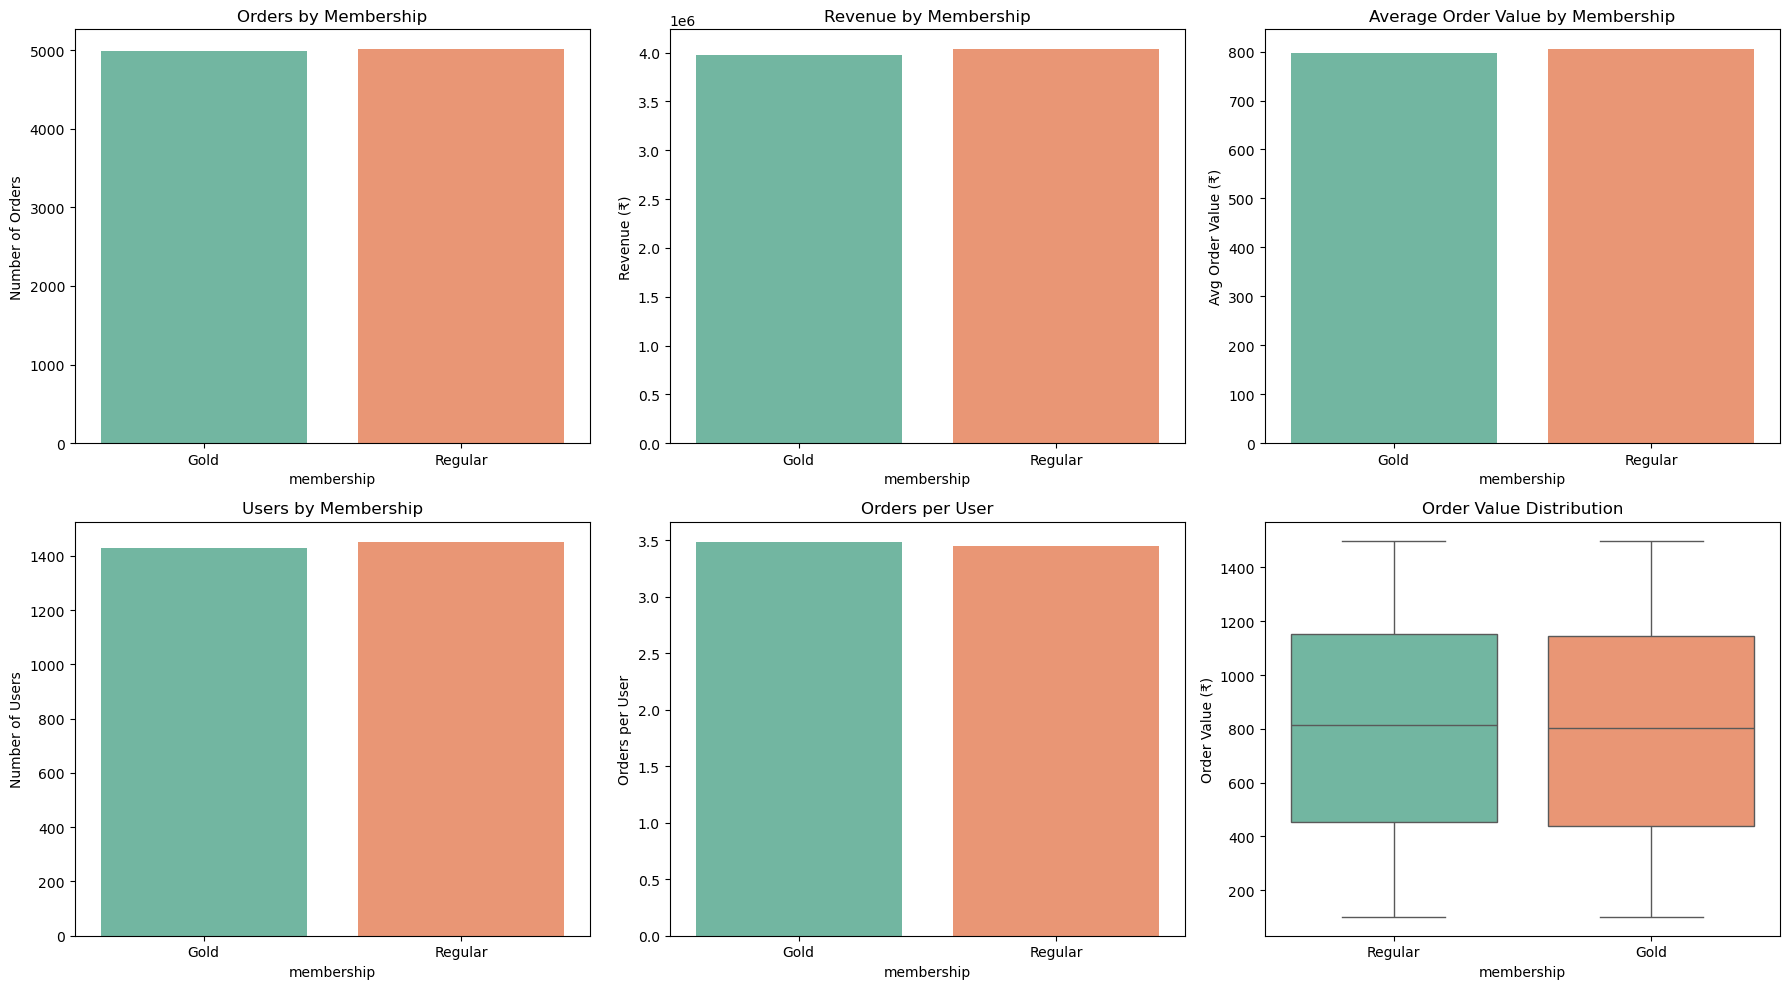

Orders by Gold members: 50%

Highest average order value but less than 20 total orders:
Grand Cafe Punjabi: 32 orders, Avg: ₹765.41
Grand Restaurant South Indian: 29 orders, Avg: ₹842.57
Ruchi Mess Multicuisine: 40 orders, Avg: ₹851.23
Ruchi Foods Chinese: 19 orders, Avg: ₹686.60

Combination Revenue Comparison:
  Gold + Indian: ₹979,312
  Gold + Italian: ₹1,005,779
  Regular + Indian: ₹992,100
  Regular + Chinese: ₹952,791

Gold vs Regular order value: -1.0% difference


In [38]:
# membership impact analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# membership data 
membership_stats = final_data.groupby('membership').agg(
    total_orders=('order_id', 'count'),
    total_revenue=('total_amount', 'sum'),
    avg_order_value=('total_amount', 'mean'),
    user_count=('user_id', 'nunique')
).reset_index()

membership_stats['orders_per_user'] = membership_stats['total_orders'] / membership_stats['user_count']

# plot 1 - orders distribution by membership
sns.barplot(x='membership', y='total_orders', data=membership_stats, hue='membership', ax=axes[0,0], palette='Set2', legend=False)
axes[0,0].set_title('Orders by Membership')
axes[0,0].set_ylabel('Number of Orders')

# plot 2 - revenue distribution by membership
sns.barplot(x='membership', y='total_revenue', data=membership_stats,hue='membership', ax=axes[0,1], palette='Set2', legend=False)
axes[0,1].set_title('Revenue by Membership')
axes[0,1].set_ylabel('Revenue (₹)')

# plot 3 - avg order value per membership
sns.barplot(x='membership', y='avg_order_value', data=membership_stats,hue='membership', ax=axes[0,2], palette='Set2', legend=False)
axes[0,2].set_title('Average Order Value by Membership')
axes[0,2].set_ylabel('Avg Order Value (₹)')

# plot 4 -  users by membership plot

sns.barplot(x='membership', y='user_count', data=membership_stats,hue='membership', ax=axes[1,0], palette='Set2', legend=False)
axes[1,0].set_title('Users by Membership')
axes[1,0].set_ylabel('Number of Users')

# plot 5 - distribution of orders per user
sns.barplot(x='membership', y='orders_per_user', data=membership_stats,hue='membership', ax=axes[1,1], palette='Set2', legend=False)
axes[1,1].set_title('Orders per User')
axes[1,1].set_ylabel('Orders per User')

# plot 6 - distribution of order values
sns.boxplot(x='membership', y='total_amount', data=final_data,hue='membership', ax=axes[1,2], palette='Set2', legend=False)
axes[1,2].set_title('Order Value Distribution')
axes[1,2].set_ylabel('Order Value (₹)')

plt.tight_layout()
plt.show()

# percentage of orders from Gold members
gold_orders_pct = (membership_stats[membership_stats['membership'] == 'Gold']['total_orders'].iloc[0] / 
                   membership_stats['total_orders'].sum() * 100)
print(f"Orders by Gold members: {round(gold_orders_pct)}%")

# restaurant analysis
print("\nHighest average order value but less than 20 total orders:")
options = ['Grand Cafe Punjabi', 'Grand Restaurant South Indian', 
           'Ruchi Mess Multicuisine', 'Ruchi Foods Chinese']

for restaurant in options:
    data = final_data[final_data['restaurant_name_x'] == restaurant]
    orders = len(data)
    avg = data['total_amount'].mean() if orders > 0 else 0
    print(f"{restaurant}: {orders} orders, Avg: ₹{avg:.2f}")

# best combination
print("\nCombination Revenue Comparison:")
options = [('Gold', 'Indian'), ('Gold', 'Italian'), ('Regular', 'Indian'), ('Regular', 'Chinese')]
for mem, cui in options:
    revenue = final_data[(final_data['membership'] == mem) & (final_data['cuisine'] == cui)]['total_amount'].sum()
    print(f"  {mem} + {cui}: ₹{revenue:,.0f}")

# value comparison
gold_value = membership_stats[membership_stats['membership'] == 'Gold']['avg_order_value'].iloc[0]
regular_value = membership_stats[membership_stats['membership'] == 'Regular']['avg_order_value'].iloc[0]
difference = ((gold_value - regular_value) / regular_value * 100)
print(f"\nGold vs Regular order value: {difference:.1f}% difference")

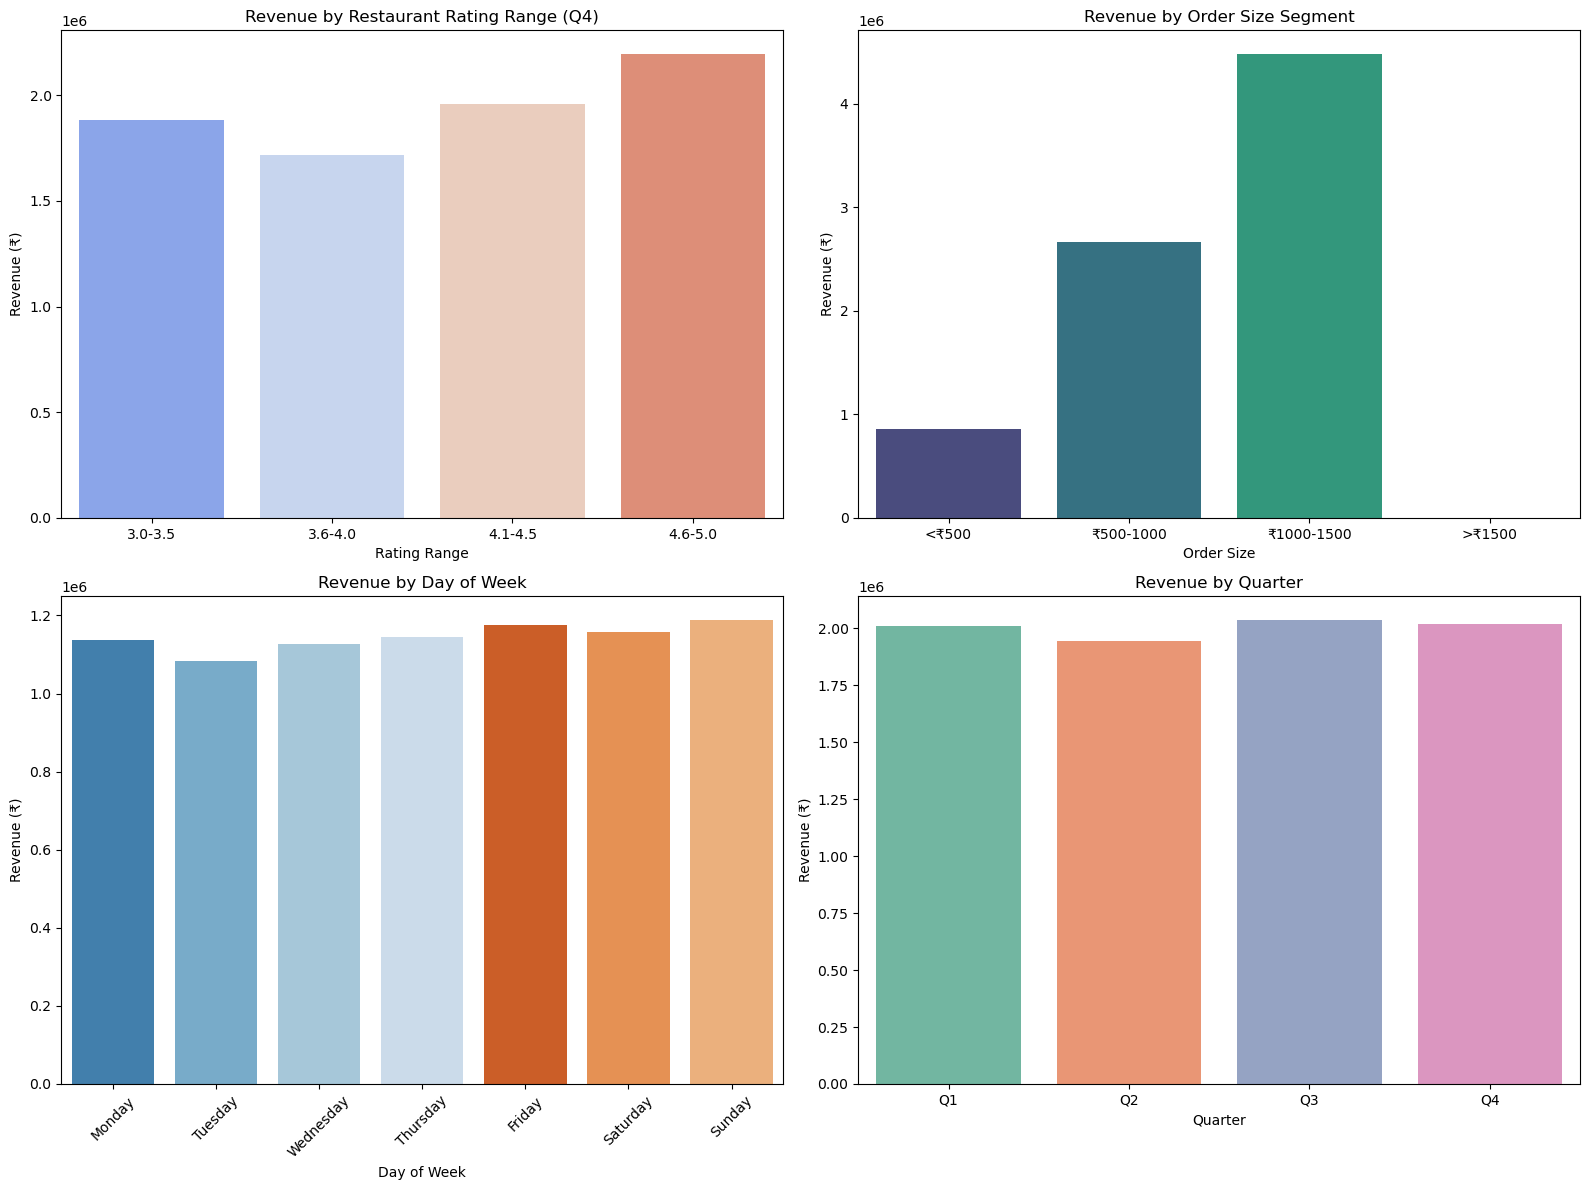

Rating range with highest revenue = 4.6-5.0

Revenue Distribution Statistics:
Minimum order value: ₹100.20
Maximum order value: ₹1499.83
Average order value: ₹801.16
Median order value: ₹806.30
Standard deviation: ₹405.46

Revenue by Segment:
<₹500: ₹856,231 (10.7%)
₹500-1000: ₹2,669,167 (33.3%)
₹1000-1500: ₹4,486,227 (56.0%)
>₹1500: ₹0 (0.0%)

Day with highest revenue: Sunday
Quarter with highest revenue: Q3 


In [26]:
# revenue distribution and seasonality analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# plot 1 - revenue distribution across rating ranges
final_data['rating_range'] = pd.cut(final_data['rating'], bins=[3.0, 3.5, 4.0, 4.5, 5.0],labels=['3.0-3.5', '3.6-4.0', '4.1-4.5', '4.6-5.0'])

rating_range_revenue = final_data.groupby('rating_range', observed=False)['total_amount'].sum()
sns.barplot(x=rating_range_revenue.index, y=rating_range_revenue.values, hue=rating_range_revenue.index, ax=axes[0,0], palette='coolwarm', legend=False)
axes[0,0].set_title('Revenue by Restaurant Rating Range (Q4)')
axes[0,0].set_xlabel('Rating Range')
axes[0,0].set_ylabel('Revenue (₹)')

# plot 2 - revenue distribution by order size
final_data['order_size'] = pd.cut(final_data['total_amount'], bins=[0, 500, 1000, 1500, float('inf')],labels=['<₹500', '₹500-1000', '₹1000-1500', '>₹1500'])

size_segments = final_data.groupby('order_size', observed=False)['total_amount'].sum()
sns.barplot(x=size_segments.index, y=size_segments.values,hue=size_segments.index, ax=axes[0,1], palette='viridis', legend=False)
axes[0,1].set_title('Revenue by Order Size Segment')
axes[0,1].set_xlabel('Order Size')
axes[0,1].set_ylabel('Revenue (₹)')

# plot 3 - weekly seasonal trends
final_data['day_of_week'] = final_data['order_date'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
final_data['day_of_week'] = pd.Categorical(final_data['day_of_week'], categories=day_order, ordered=True)

daily_revenue = final_data.groupby('day_of_week', observed=False)['total_amount'].sum()
sns.barplot(x=daily_revenue.index, y=daily_revenue.values,  hue=daily_revenue.index, ax=axes[1,0], palette='tab20c', legend=False)
axes[1,0].set_title('Revenue by Day of Week')
axes[1,0].set_xlabel('Day of Week')
axes[1,0].set_ylabel('Revenue (₹)')
axes[1,0].tick_params(axis='x', rotation=45)

# plot 4: quarterly seasonality
quarterly_revenue = final_data.groupby('quarter')['total_amount'].sum()
quarters = ['Q1', 'Q2', 'Q3', 'Q4']
sns.barplot(x=quarters, y=quarterly_revenue.values,  hue=quarters, ax=axes[1,1], palette='Set2', legend=False)
axes[1,1].set_title('Revenue by Quarter')
axes[1,1].set_xlabel('Quarter')
axes[1,1].set_ylabel('Revenue (₹)')

plt.tight_layout()
plt.show()

# highest revenue by rating range
print(f"Rating range with highest revenue = {rating_range_revenue.idxmax()}")

# revenue distribution summary
print(f"\nRevenue Distribution Statistics:")
print(f"Minimum order value: ₹{final_data['total_amount'].min():.2f}")
print(f"Maximum order value: ₹{final_data['total_amount'].max():.2f}")
print(f"Average order value: ₹{final_data['total_amount'].mean():.2f}")
print(f"Median order value: ₹{final_data['total_amount'].median():.2f}")
print(f"Standard deviation: ₹{final_data['total_amount'].std():.2f}")

# percentage of revenue by segments
total_revenue = final_data['total_amount'].sum()
segments = final_data.groupby('order_size', observed=False)['total_amount'].sum()
print(f"\nRevenue by Segment:")
for segment, revenue in segments.items():
    percentage = (revenue / total_revenue) * 100
    print(f"{segment}: ₹{revenue:,.0f} ({percentage:.1f}%)")

#  insights
print(f"\nDay with highest revenue: {daily_revenue.idxmax()}")
print(f"Quarter with highest revenue: Q{quarterly_revenue.idxmax()} ")

In [27]:
# numerical analysis

gold_orders = final_data[final_data['membership'] == 'Gold'].shape[0]
print(f"Total orders by Gold members: {gold_orders}")

hyderabad_revenue = final_data[final_data['city'] == 'Hyderabad']['total_amount'].sum()
print(f"Total revenue from Hyderabad: ₹{round(hyderabad_revenue)}")

distinct_users = final_data['user_id'].nunique()
print(f"Distinct users with at least one order: {distinct_users}")

gold_avg_value = final_data[final_data['membership'] == 'Gold']['total_amount'].mean()
print(f"Average order value for Gold members: ₹{gold_avg_value:.2f}")

high_rating_orders = final_data[final_data['rating'] >= 4.5].shape[0]
print(f"Orders with rating ≥ 4.5: {high_rating_orders}")

top_city = final_data[final_data['membership'] == 'Gold'].groupby('city')['total_amount'].sum().idxmax()
top_city_gold_orders = final_data[(final_data['membership'] == 'Gold') & (final_data['city'] == top_city)].shape[0]
print(f"Orders in top revenue city (Gold members only): {top_city_gold_orders}")


Total orders by Gold members: 4987
Total revenue from Hyderabad: ₹1889367
Distinct users with at least one order: 2883
 Average order value for Gold members: ₹797.15
Orders with rating ≥ 4.5: 3374
Orders in top revenue city (Gold members only): 1337
